L'objet de ce projet est d'étudier des algorithmes de scoring aidant à la décision d'un accord de prêt. 

La finalité est d'utiliser des historiques de prêts et d'informations financières pour évaluer la probabilité de remboursement du prêt par le candidat.

Le modèle doit donc être facilement interprétable. 

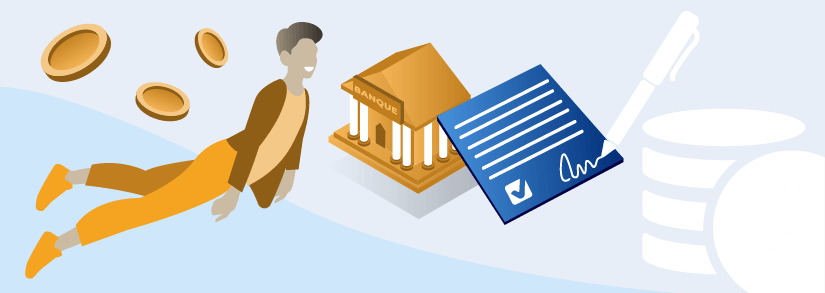

Ce notebook présente la démarche de recherche d'hyperparamètres et d'optimisation du bénéfice supplémentaire fait par la banque grâce au modèle en fonction des différentes techniques de traitement des données.

# Importation des données et des librairies

## Importation des librairies utiles au projet

In [1]:
# numpy and pandas pour la manipulation des données
# Parfois les pandas font pipi en faisant le poirier (franchement celle-ci vaut le détour!)
import pandas as pd
import numpy as np

# matplotlib and seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# File system management
import os

In [2]:
# Les packages personnalisées
import mes_packages.Charles_Xavier.modeles_simples as my_mdl_s
import mes_packages.Charles_Xavier.evaluation_modele as my_eval
from mes_packages.Mystique_Raven.special_p4 import clean_fe_application

In [3]:
# Palette de couleur
a, b, c, d, e = [
    plt.cm.Blues, plt.cm.Oranges, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples
]

## Importation des librairies pour l'apprentissage machine

L'intégralité des librairies nécessaires sont chargées ici pour éviter de surcharger le notebook.

In [4]:
# sklearn metrics pour quantifier la qualité des prédictions
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

# sklear impute pour effectuer des imputation de valeurs manquantes
from sklearn.impute import SimpleImputer

# Pour séparer train/test et faire des validations croisées et des stratification ainsi que des grilles de recherches
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# Pour faire un over sampling
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE

# Pour effectuer une PCA avant le modèle
from sklearn.decomposition import PCA

# Les différents modèles testés
from sklearn.neighbors import KNeighborsClassifier

## Préparation des bases de données à partir des fonctions personnalisées de features engineering

### La base de données application_train seule avec les nouvelles variables

In [5]:
import os
from dotenv import load_dotenv  # Pour récupérer les variables d'environnement

load_dotenv('var.env')  # Importation des variables d'environnement

# Récupération des variables d'environnement
chemin = os.environ['CHEMIN']

In [6]:
application_train = pd.read_csv(chemin + "application_train.csv",
                                low_memory=False)
''' Cette fonction procède au nettoyage des variables
de la base de données application.
Ensuite, elle ajoute de nouvelles variables pertinentes
    à la base de données

Entrées :
df : le dataframe

Renvoie :
df : le dataframe nettoyé et avec de nouvelles variables'''

# Nettoyage de la base de données et ajout de nouvelles variables
df_nv = clean_fe_application(application_train)
df_nv.replace([np.inf, -np.inf], np.nan, inplace=True)
df_nv = df_nv.fillna(0)


*Fonction by Sandy M.*

La base de données avant nettoyage présente  307511 entrées pour  122 variables
~ Remplacement des valeurs erronées et des valeurs manquantes par "unknown" : effectué
~ Conversion des $ en k$ : effectué
~ Correction du signe des données en jours : effectué
~ Correction des valeurs aberrantes : effectué
~ Imputation des valeurs manquantes par les moyennes ou les médianes: effectué
~ Suppression des variables non-pertinentes pour cette étude : effectué

 -----L'étape de nettoyage des variables est terminée-----

La base de données après nettoyage présente 307506 entrées pour 56 variables.
 66 variables ont été écartées de l'étude et 56 variables ont été nettoyées
Ajout des variables 'MONTANT_PAR_JOB_MED',  'MONTANT_PAR_POSTE_MED' et 'MONTANT_PAR_EDU_MED'
Ajout des variables 'RAPPORT_CREDIT_INCOME',  'RAPPORT_ANNUITY_INCOME', 'RAPPORT_CREDIT_ANNUITY',  'RATIO_CREDIT_GOODS', 'EXT_SOURCES_MOY' et   'INCOME_PAR_MEMB_FAM'
Ajout des variables 'RATIO_CAR_BIRTH' et  'RATIO_PHONE_BIRTH'
Ajout des

# Explication de la démarche

Ce projet s'inscrit dans l'optique de déterminer quel modèle est le plus performant pour notre problématique. Mais la performance dépend justement de la finalité métier. Cette section prend un modèle simple (l'algorithme KNN) pour expliquer la démarche de sélection des paramètres initiaux et la méthode d'évaluation du modèle.

## Le modèle de démonstration KNN

Avant de commencer, il est important de prendre un échantillon de la base de données. En effet, les temps de calcul peuvent être très longs. Et dans cette étude, nous voulons tester plusieurs paramètres, donc faire de nombreux calculs. Prendre un échantillon permet de réduire le temps de calcul sans altérer les performances des modèles. Un fois que nous aurons trouvé un modèle qui nous correspond, nous étudierons l'impact de la taille de l'échantillon.

In [7]:
df = df_nv.sample(10000)
del df_nv

Nous allons commencer avec un modèle très simple : le modèle KNN, l'algorithme des K plus proches voisins ou K-nearest neighbors (KNN). Il consiste à trouver les plus proches voisins d'une ligne et de leur attribuer leur valeur pour la cible (dans notre cas, la variable 'TARGET').
La fonction suivante présente une fonction type pour l'élaboration d'un modèle ainsi que la prédiction sur un échantillon test.

Pour vous familiariser avec le modèle KNN :
    
    - http://vision.stanford.edu/teaching/cs231n-demos/knn/
    - https://jjfiv.github.io/cs451-s2021/knn.html


*Fonction by Sandy M.*

temps de calcul : 0.6 sec
Matrice de confusion


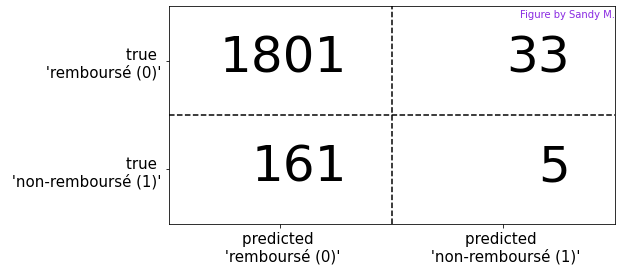

il y a : 
 1801 Vrais Négatifs (le prêt a été remboursé) 
 33 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 161 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 5 Vrais Positifs (le prêt n'a pas été remboursé) 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1834
           1       0.13      0.03      0.05       166

    accuracy                           0.90      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.85      0.90      0.87      2000



In [8]:
""" Cette fonction effectue l'entraînement et la prédiction d'un modèle.
Entrées :
df : le dataframe
nom_target : la variable cible
nom_modele : le nom du modèle (string)
le_modèle : le modèle (classe)
test_size : taille du jeu de test (float)
evaluation : si 'oui', n'affiche pas le compte rendu de la performance du modèle
smote : si != 'non' effectue un rééquilibrage des labels
pca : si != 'non' effectue une PCA avant la modélisation
afficher_roc : si "oui" affiche les courbes roc et auroc

Renvoie :
prediction : le vecteur avec les valeurs issues de la prédiction
y_test : le vecteur avec les valeurs du jeu de test"""

# Prédiction à l'aide d'un modèle KNN simple
prediction, y_test = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']), "TARGET", 'knn',
    KNeighborsClassifier(n_neighbors=3))

Il est possible de voir que la précision est très bonne sur les cibles '0' (remboursé) et plutôt mauvais sur les cible '1' (non-remboursés). Au sein de la base de données, il y a 92% de 0 et 8 % de 1, il est très facile d'avoir de bon résultat pour prédire '0' étant donné sa forte fréquence.

In [9]:
comparaison = y_test.copy(deep=True)
comparaison['PREDICTION'] = prediction
comparaison.head(5)

,TARGET,PREDICTION
126896,0,0
160315,0,0
163194,0,0
44905,0,1
241549,0,0


In [10]:
comparaison[comparaison['TARGET'] == 1].head(5)

,TARGET,PREDICTION
133206,1,0
206950,1,0
191145,1,0
282618,1,0
11115,1,0


La fonction ci-dessus propose plusieurs étapes qui pourraient être faites hors de la fonction car elles seront communes à tous les modèles qui seront utilisés pour effectuer les comparaisons.
C'est le cas des étapes suivantes :
- l'imputation de valeurs manquantes
- l'encodage des variables qualitatives
- la séparation du jeu d'entraînement (train) et du jeu de test (test)
- la normalisation des variables numériques.


Deux précautions doivent être prises :
- la normalisation doit se faire après la séparation du jeu de données en train/test pour éviter toute fuite d'information entre les deux jeux de données
- la normalisation ne doit surtout pas se faire sur les variables qui ont été encodées.

### La préparation des données : encodage / standardisation / imputation

Dans notre cas, les variables qualitatives ne contiennent pas des valeurs ordinales, c'est à dire que les valeurs ne permettent pas de classer les modalités suivant un ordre. Ainsi, pour les encoder, il est préférable d'utiliser un encodage "One Hot Encoding" plutôt qu'un encodage "Label Encoding" pour davantage de performance. 

In [11]:
df_test = df[["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL"]]

In [12]:
df_test.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL
159606,Revolving loans,90.0
22275,Revolving loans,67.5
178058,Cash loans,198.0
18785,Cash loans,225.0
233940,Cash loans,180.0


In [13]:
""" Cette fonction prépare le dataframe pour l'entraînement
# Impute les valeurs manquantes des variables quantitatives
# Effectue une standardisation sur les valeurs des variables quantitatives
# (nouvelle valeur = (x_moyenne)/ecart standard)
# Impute les valeurs manquantes des variables qualitatives
# Effectue un encodage "OneHotEncoder" (x colonnes pour x modaliés)
#Le preprocessor contient les préparations des variables quantitatives et des variables qualitatives

Entrées :
df : le dataframe

Renvoie :
df_resultat : le dataframe préparé"""

# Préparation des données pour la phase d'entraînement et la phase de test des modèles.
df_resultat = my_mdl_s.df_preproc(df_test)


*Fonction by Sandy M.*

In [14]:
comparaison = df_test.copy(deep=True)
comparaison['AMT_INCOME_TOTAL / Standardisé'] = df_resultat[:, 0]
comparaison['NAME_CONTRACT_TYPE_Cash loans'] = df_resultat[:, 1]
comparaison['NAME_CONTRACT_TYPE_Revolving loans'] = df_resultat[:, 2]
comparaison['TARGET'] = df['TARGET']
comparaison.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_INCOME_TOTAL / Standardisé,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,TARGET
159606,Revolving loans,90.0,-0.768868,0.0,1.0,0
22275,Revolving loans,67.5,-0.991079,0.0,1.0,0
178058,Cash loans,198.0,0.297748,1.0,0.0,0
18785,Cash loans,225.0,0.564402,1.0,0.0,0
233940,Cash loans,180.0,0.119979,1.0,0.0,0


In [15]:
del df_test

Ici, on voit bien que la variable 'NAME_CONTRACT_TYPE' a été encodée. Elle a été remplacée par deux nouvelles variables (deux car c'est le nombre de modalité de cette variable) :
- NAME_CONTRACT_TYPE_Cash loans
- NAME_CONTRACT_TYPE_Revolving loans.

Aussi, la variable 'AMT_INCOME_TOTAL' a été standardisée. C'est à dire que l'algorithme a fait la différence entre la valeur de la variable et sa moyenne puis a divisé le tout par son écart-type. Ainsi, les valeurs sont comprises entre -1 et 1. Le calcul se fait de façon beaucoup plus rapide grâce à cette méthode.                                                                                                                         

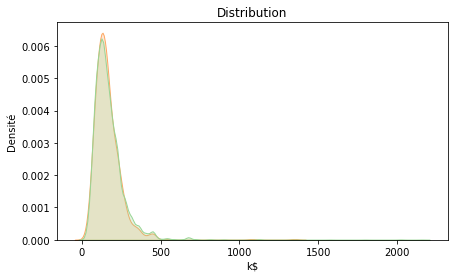

In [16]:
plt.figure(figsize=(7, 4))

sns.kdeplot(comparaison.loc[comparaison['TARGET'] == 1, 'AMT_INCOME_TOTAL'],
            shade=True,
            label='target == 1',
            color=b(0.4))

sns.kdeplot(comparaison.loc[comparaison['TARGET'] == 0, 'AMT_INCOME_TOTAL'],
            shade=True,
            label='target == 0',
            color=d(0.4))

plt.xlabel('k$')
plt.ylabel('Densité')
plt.title('Distribution')
plt.show()

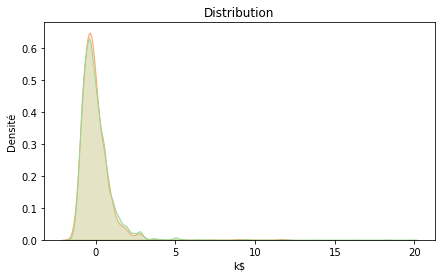

In [17]:
plt.figure(figsize=(7, 4))

sns.kdeplot(comparaison.loc[comparaison['TARGET'] == 1,
                            'AMT_INCOME_TOTAL / Standardisé'],
            shade=True,
            label='target == 1',
            color=b(0.4))

sns.kdeplot(comparaison.loc[comparaison['TARGET'] == 0,
                            'AMT_INCOME_TOTAL / Standardisé'],
            shade=True,
            label='target == 0',
            color=d(0.4))

plt.xlabel('k$')
plt.ylabel('Densité')
plt.title('Distribution')
plt.show()

Quand le pourcentage idéal de séparation des données de test et d'entraînement sera défini, nous pourrons, si besoin, effectuer ces étapes avant de lancer les fonctions des modèles d'apprentissage machine.

## La matrice de confusion

La matrice de confusion donne une idée de la performance d'un modèle.
Il s'agit d'une matrice qui reporte :
    - les vrais positifs (cible = 1 ou prédiction = 1)
    - les faux négatifs (cible = 1 ou prédiction = 0)
    - les vrais négatifs (cible = 0 ou prédiction = 0)
    - les faux positifs (cible = 0 ou prédiction = 1)
Elle s'obtient grâce à la fonction confusion_matrix

In [18]:
print("Matrice de confusion")
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
print(
    'il y a : \n', tn, 'Vrais Négatifs (le prêt a été remboursé) \n', fp,
    "Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) \n",
    fn, 'Faux Négatifs (le prêt a été remboursé, le modèle dit que non)\n', tp,
    "Vrais Positifs (le prêt n'a pas été remboursé) \n")

Matrice de confusion
il y a : 
 1801 Vrais Négatifs (le prêt a été remboursé) 
 33 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 161 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 5 Vrais Positifs (le prêt n'a pas été remboursé) 



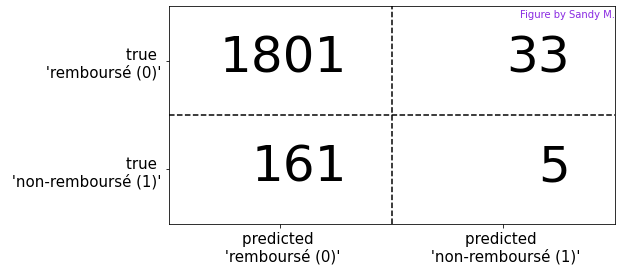

In [19]:
""" Cette fonction affiche un tableau avec la matrice de confusion
Entrées :
y_test : les valeurs tests
prediction : le vecteur avec les valeurs issues de la prédiction"""

# Affichage de la matrice de confusion de la prédiction
my_eval.plot_confusion_matrix_illustration(y_test, prediction)

## Les différents scores

Les algorithmes d'apprentissage sont évalués grâce à des outils statistiques. Ces outils donnent un score à l'algorithme suivant la façon dont l'utilisateur juge la performance de l'apprentissage.

### recall (rappel) = sensibilité = Taux de Vrai Positif = 1 - Taux de Faux Négatif

La sensibilité , qui est la même chose que le rappel , est également appelée le vrai taux positif (TPR). Elle représente la fraction de toutes les prédictions positives correctes. Il se calcule en faisant le rapport entre le nombre de vrais positifs (tp) et la somme des positifs initiaux (tp + fn).

In [20]:
recall_calc = tp / (tp + fn)
round(recall_calc, 3)

0.03

Le module sklearn permet de trouver directement la sensibilité grâce à la fonction recall_score.

In [21]:
round(recall_score(y_test, prediction), 3)

0.03

La sensibilité permet d'évaluer la façon dont l'algorithme détecte les cibles positives. Dans le cas de notre étude, c'est un score d'une importance capitale. Plus la valeur de ce score est élevé, plus celà signifie que le modèle a pu permettre la détection des clients qui n'ont pas été en mesure d'assurer le remboursement de leur prêt.

### précision

La précision évalue la capacité du modèle à ne pas classifier une cible initialement négative en cible positive. Il se calcule en faisant la rapport entre le nombre de cible positive correctement prédite (tp) et la somme des vrais positifs et des faux positifs (tp + fp).

In [22]:
precision_calc = tp / (tp + fp)
round(precision_calc, 3)

0.132

Le module sklearn permet de trouver directement la précision grâce à la fonction precision_score.

In [23]:
round(precision_score(y_test, prediction), 3)

0.132

La précision n'est certes pas le score le plus important pour notre problématique. Néanmoins, il est nécessaire de l'évaluer secondairement à la sensibilité. En effet, imaginons que le modèle prédise l'intégralité des cibles comme positives. La sensibilité sera maximum, plus aucun client n'aura de défaut de paiement. Mais il n'y aura plus non plus de client à qui le crédit sera accordé et qui rapporteront des bénéfices sous forme d'intérets. Il faut donc que les valeurs du couple (senbilitité,précision) soient les plus élevées possibles.

### F - mesure

La F-mesure est la moyenne harmonique de la précision et de la sensibilité. Elle indique à la fois la précision du modèle  (à quel point il classifie correctement les cibles), ainsi que sa robustesse (il ne classifie pas de façon trop importante des cibles positives en prédiction négative).

In [24]:
fmesure_calc = 2 * (precision_calc * recall_calc) / (precision_calc +
                                                     recall_calc)
round(fmesure_calc, 3)

0.049

In [25]:
fmesure_calc = (2 * tp) / (2 * tp + fp + fn)
round(fmesure_calc, 3)

0.049

Le module sklearn permet de trouver directement la f-mesure grâce à la fonction f1_score.

In [26]:
round(f1_score(y_test, prediction), 3)

0.049

### Rapport de classification

La fonction classification_report permet d'afficher la précision, la sensibilité et la f-mesure.

In [27]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1834
           1       0.13      0.03      0.05       166

    accuracy                           0.90      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.85      0.90      0.87      2000



### Spécificité = Taux de Vrai Négatif = 1 - Taux de Faux Positif

La spécificité mesure la capacité du modèle à donner une prédiction négative correcte (vrai négatif).

In [28]:
specificite_calc = tn / (fp + tn)
round(specificite_calc, 2)

0.98

## Le calcul gain / perte

Les différents scores permettent d'avoir une idée de la performance des modèles testés. Néanmoins, les sommes perdues à cause des défauts de remboursement peuvent varier de plusieurs puissance de 10.
Par exemple, si la senbilité est très haute, au delà de 90% mais que les 10% de prêts non-remboursés représentent des pertes 10 à 100 fois plus élevées que les économies réalisées, le modèle ne sera pas pertinents pour la problématique.

Pour remédier à celà il faut trouver un moyen de calculer un rapport gain/perte ou d'évaluer le bénéfice supplémentaire qu'apporterait le moyen de détection présenté.

Pour le calcul du rapport gain / perte, 2 choix se présentent :

- Choix 1 : calcul de la somme économisées par clients demandeurs (en k\\$) =
(somme des sommes de tp (non remboursé non prété) - somme des sommes des intérets des fp (remboursé non prété)) / (nombre de demandes)
- Choix 2 : calcul de la somme économisée par k\\$ gagnés =
(somme des sommes de tp (non remboursé non prété) - somme des sommes des intérets des fp (remboursé non prété)) / (sommes gagnées - sommes perdues)


*Fonction by Sandy M.*

temps de calcul : 0.6 sec
Matrice de confusion


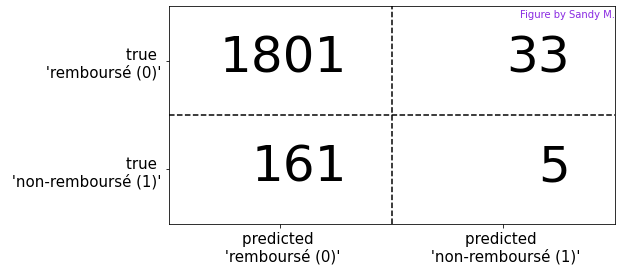

il y a : 
 1801 Vrais Négatifs (le prêt a été remboursé) 
 33 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 161 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 5 Vrais Positifs (le prêt n'a pas été remboursé) 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1834
           1       0.13      0.03      0.05       166

    accuracy                           0.90      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.85      0.90      0.87      2000



In [29]:
# Prédiction à l'aide d'un modèle KNN simple
prediction, y_test = my_mdl_s.modele_simple_basique(df.drop(
    columns=['SK_ID_CURR']), "TARGET", 'knn', KNeighborsClassifier(n_neighbors=3))

Pour plus de praticité, deux fonctions sont créées pour calculer directement les différents bénéfices supplémentaires et visualiser les sommes gagnées/perdues/économisées/non gagnées.

### Calcul des bénéfices sans modèle

Pour un taux d'intérêt à 5% et l'hypothèse que le non remboursement se fait sur l'entièreté du crédit, le calcul des bénéfices se fait comme suit :

Le bénéfice est fortement négatif. Cela est dû au fait que nous avons fait l'hypothèse que le prêt n'est pas du tout remboursé. La base de données ne donne pas d'information sur la proportion du prêt qui a été remboursée. Il n'est pas possible de calculer la perte réelle. Mais il est possible d'évaluer la proportion de prêt non-remboursée pour que le bénéfice soit à zéro et de comparer ensuite la perte avec le modèle en prenant en compte la même proportion.

### Calcul de l'économie par demandeur et par dollar investi

Deux mesures sont aussi intéressantes que le bénéfice global. D'abord le bénéfice supplémentaire fait pour chaque demande. Il s'affranchit du nombre de clients qui ont fait une demande de prêt. Ensuite, le bénéfice supplémentaire pour chaque dollar prêté. Il donne une idée de la plus-value qu'apporte l'application des différents algorithmes construits pendant ce projet.


*Fonction by Sandy M.*

la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  94299.0 k$
le bénéfice sans modèle est  -39610.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  54689.0 k$
le bénéfice supplémentaire sans modèle est  -0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  56.36 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  0.55 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  53777.0 k$
la somme supplémentaire perdue avec modèle est  53213.0 k$
le bénéfice supplémentaire avec modèle est  564.0 k$


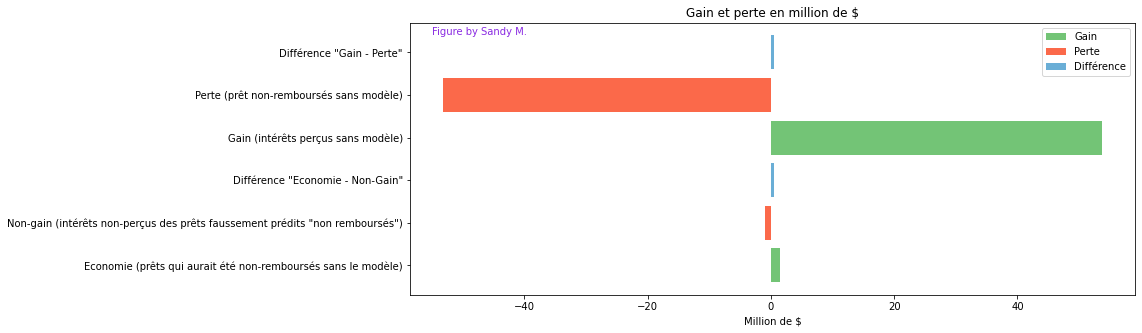

In [30]:
""" Cette fonction permet de calculer le bénéfice supplémentaire qu'aurait fait
l'organisme préteur si le modèle avait été utilisé avant l'attribution ou non du prêt 

Entrées :
y : le vecteur correspondant à la cible du jeu de test
prediction : le vecteur avec les valeurs issues de la prédiction
df : le dataframe qui contient les montants des prêts demandés
graph : si 'oui', affichage d'un graphique avec les différents bénéfices (par défaut = 'non')
return_values  : si 'oui'
    Renvoie :
    benefice_total = le bénéfice supplémentaire total fait grâce au modèle en k$
    eco_par_demandeur = le bénéfice supplémentaire par demandeur en $
    eco_par_dollar = le bénéfice supplémentaire par dollar investi en $
"""

# Calcul des bénéfices qui auraient été réalisés grâce au modèle
my_eval.benefice(y_test, prediction, df, texte='oui', graph='oui')

In [31]:
# Calcul des bénéfices qui auraient été réalisés grâce au modèle
b1, b2, b3 = my_eval.benefice(y_test, prediction, df, return_values='oui')
print('le bénéfice supplémentaire avec le modèle est ', b1, 'k$')
print('le bénéfice supplémentaire par demandeur avec le modèle est ', b2, '$')
print('le bénéfice supplémentaire par dollar investi avec le modèle est ', b3, '$')

le bénéfice supplémentaire avec le modèle est  564.0 k$
le bénéfice supplémentaire par demandeur avec le modèle est  56.0 $
le bénéfice supplémentaire par dollar investi avec le modèle est  1.0 $


## Influence des différents paramètres

### effet du splitting

L'échantillon de données est séparé en 2 parties : le jeu d'entrainement, et le jeu de test. La proportion de train/test peut fortement influencer la performance d'un modèle d'apprentissage.

In [32]:
# Initialisation du tableau des résultats
df_resultats = []
i = 0

# Etude l'impact de la variable du % de splitting
for s in range(1, 9):
    sp = s / 10
    prediction, y_test, score_train, score_test, temps = my_mdl_s.modele_simple_basique(
        df.drop(columns=['SK_ID_CURR']),
        "TARGET",
        'knn',
        KNeighborsClassifier(n_neighbors=3),
        test_size=sp,
        evaluation='oui')

    benef, edem, edol = my_eval.benefice(
        y_test, prediction, df, return_values='oui')

    df_resultats = my_eval.tableau_resultats(
        df_resultats, prediction, y_test, score_train, score_test, temps, benef/sp, edem, edol, sp, i)
    i += 1
df_resultats

,valeur paramètre,errors_train,errors_test,f1_Négatifs,f1_Positifs,recall,f1,temps de calcul,Bénéfice Total,Bénéfice par demande,Bénéfice par dollar
0,0.1,6.83,9.00,0.95,0.04,0.03,0.04,0.4,560.00,6.0,0.0
1,0.2,6.76,9.70,0.95,0.05,0.03,0.05,0.6,2820.00,56.0,1.0
2,0.3,6.93,9.37,0.95,0.04,0.03,0.04,0.7,330.00,10.0,0.0
3,0.4,6.88,9.38,0.95,0.06,0.04,0.06,0.8,5755.00,230.0,1.0
4,0.5,6.92,9.20,0.95,0.07,0.04,0.07,0.8,5836.00,292.0,1.0
5,0.6,7.05,9.68,0.95,0.06,0.04,0.06,0.8,5730.00,344.0,1.0
6,0.7,7.33,9.99,0.95,0.07,0.05,0.07,0.8,7685.71,538.0,1.0
7,0.8,7.75,10.55,0.94,0.08,0.06,0.08,0.7,10011.25,801.0,2.0


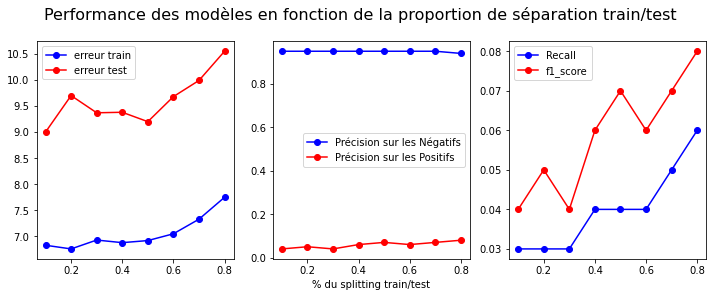

In [33]:
# Graphique des scores en fonction du % de splitting
my_eval.graphiques_scores(
    df_resultats['valeur paramètre'], df_resultats['errors_train'],
    df_resultats['errors_test'], df_resultats['f1_Négatifs'],
    df_resultats['f1_Positifs'], df_resultats['recall'], df_resultats['f1'],
    '% du splitting train/test',
    'Performance des modèles en fonction de la proportion de séparation train/test'
)

Le premier graphique représente l'erreur que fait le modèle avec le jeu d'entraînement et avec le jeu de test. Il est important que ces deux erreurs soient plutôt proches l'une de l'autre car cette proximité montre la stabilité du modèle.

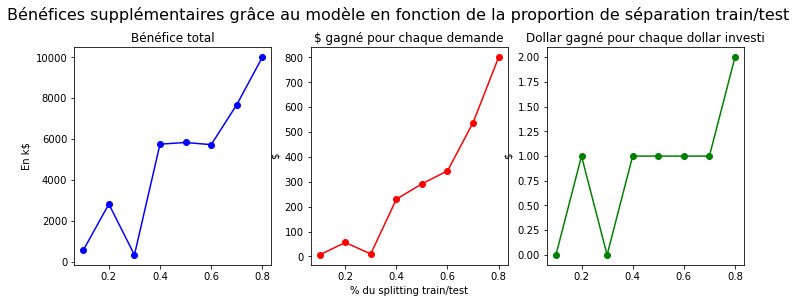

In [34]:
# Graphique des bénéfices en fonction du % de splitting
my_eval.graphiques_benefice(
    df_resultats['valeur paramètre'], df_resultats['Bénéfice Total'], df_resultats['Bénéfice par demande'],
    df_resultats['Bénéfice par dollar'], '% du splitting train/test',
    'Bénéfices supplémentaires grâce au modèle en fonction de la proportion de séparation train/test'
)

Le meilleur compromis bénéfice pour chaque dollar investi/stabilité du modèle est pour un rapport train/test de l'ordre de 80/20. C'est cette proportion qui va être choisie pour la suite des calculs car c'est le ratio optimum pour la taille de l'échantillon choisi.


*Fonction by Sandy M.*

temps de calcul : 0.6 sec
Matrice de confusion


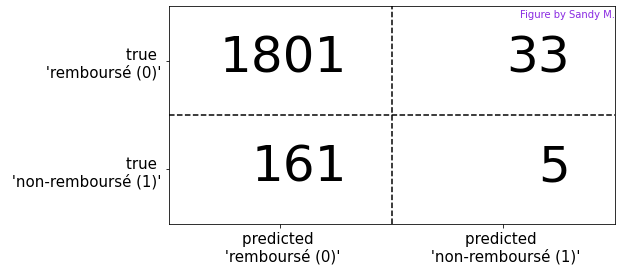

il y a : 
 1801 Vrais Négatifs (le prêt a été remboursé) 
 33 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 161 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 5 Vrais Positifs (le prêt n'a pas été remboursé) 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1834
           1       0.13      0.03      0.05       166

    accuracy                           0.90      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.85      0.90      0.87      2000



In [35]:
prediction, y_test, = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']),
    "TARGET",
    'knn',
    KNeighborsClassifier(n_neighbors=3),
    test_size=0.2)


*Fonction by Sandy M.*

la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  94299.0 k$
le bénéfice sans modèle est  -39610.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  54689.0 k$
le bénéfice supplémentaire sans modèle est  -0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  56.36 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  0.55 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  53777.0 k$
la somme supplémentaire perdue avec modèle est  53213.0 k$
le bénéfice supplémentaire avec modèle est  564.0 k$


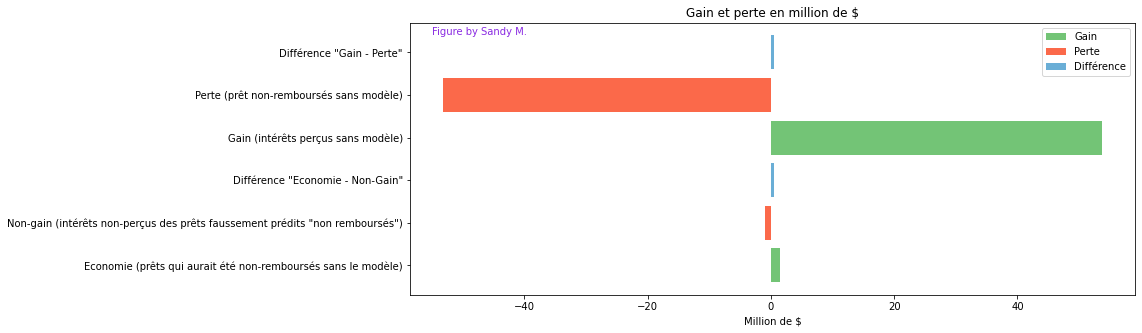

In [36]:
my_eval.benefice(y_test, prediction, df, graph='oui', texte='oui')

### hyperparamètres n pour knn (gridsearch)

Les hyperparamètres correspondent aux paramètres intrinsèques d'un modèle. Par exemple, pour le modèle KNN, le nombre de voisins k est un hyperparamètre. Il est possible d'identifier les hyperparamètres optimaux grâce à des grilles de recherche (gridsearch). Elles permettent de tester un ou plusieurs paramètres et cherchent ceux qui vont optimiser une métrique choisie.

Dans notre cas nous cherchons à optimiser le recall. Nous allons chercher le k le plus optimal pour maximiser le recall. Pour celà, nous utilisons une validation croisée. Cela consiste à découper la base de données en n parties, n-1 parties "train" et 1 partie test. L'apprentissage est réalisé sur les n-1 parties "train" et la prédiction s'effectue sur la partie test. L'opération est recommencer n fois, de sorte que chaque partie devient une partie "test" à un moment donné.

La robustesse du modèle peut s'évaluer quant à la similarité des n scores obtenus.

In [37]:
# Recherche sur grille pour l'hyperparamètre k
my_mdl_s.grid_modele(df.drop(columns=['SK_ID_CURR']),
                     "TARGET",
                     KNeighborsClassifier(), {'n_neighbors': [
                         3, 4, 5, 6, 7, 8, 9, 10]},
                     cv=5,
                     score='recall')

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 3}
Résultats de la validation croisée :
recall = 0.046 (+/-0.021) for {'n_neighbors': 3}
recall = 0.014 (+/-0.012) for {'n_neighbors': 4}
recall = 0.024 (+/-0.027) for {'n_neighbors': 5}
recall = 0.008 (+/-0.018) for {'n_neighbors': 6}
recall = 0.011 (+/-0.022) for {'n_neighbors': 7}
recall = 0.002 (+/-0.006) for {'n_neighbors': 8}
recall = 0.003 (+/-0.013) for {'n_neighbors': 9}
recall = 0.002 (+/-0.006) for {'n_neighbors': 10}

Sur le jeu de test : 0.030


Le seul inconvénient dans notre cas est que les métriques statistiques ne sont pas les seuls éléments qui permettent d'évaluer la qualité d'un modèle. Il faut impérativement que le modèle puisse aussi permettre de faire un bénéfice maximum.
Regardons si en discriminant à l'aide des différents calculs des bénéfices nous pouvons faire le même constat ( à savoir que k = 3 voisins est optimal pour ce modèle).

In [38]:
# Initialisation du tableau des résultats
df_resultats = []
i = 0

# Evaluation de l'impact du nombre de voisins
for k in range(3, 10):
    prediction, y_test, score_train, score_test, temps = my_mdl_s.modele_simple_basique(
        df.drop(columns=['SK_ID_CURR']),
        "TARGET",
        'knn',
        KNeighborsClassifier(n_neighbors=k),
        test_size=0.2,
        evaluation='oui')

    benef, edem, edol = my_eval.benefice(
        y_test, prediction, df, return_values='oui')

    df_resultats = my_eval.tableau_resultats(
        df_resultats, prediction, y_test, score_train, score_test, temps, benef, edem, edol, k, i)
    i += 1
df_resultats

,valeur paramètre,errors_train,errors_test,f1_Négatifs,f1_Positifs,recall,f1,temps de calcul,Bénéfice Total,Bénéfice par demande,Bénéfice par dollar
0,3.0,6.76,9.70,0.95,0.05,0.03,0.05,0.6,564.0,56.0,1.0
1,4.0,7.46,8.65,0.95,0.00,0.00,0.00,0.6,-164.0,-16.0,-0.0
2,5.0,7.37,9.00,0.95,0.02,0.01,0.02,0.6,109.0,11.0,0.0
3,6.0,7.67,8.45,0.96,0.01,0.01,0.01,0.6,42.0,4.0,0.0
4,7.0,7.63,8.55,0.96,0.01,0.01,0.01,0.6,11.0,1.0,0.0
5,8.0,7.74,8.40,0.96,0.00,0.00,0.00,0.7,-51.0,-5.0,-0.0
6,9.0,7.70,8.35,0.96,0.02,0.01,0.02,0.6,485.0,49.0,0.0


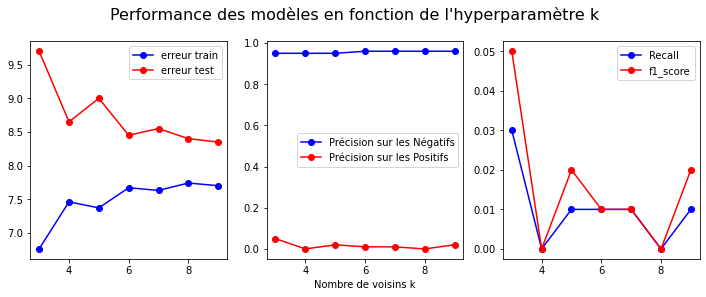

In [39]:
# Graphique des scores en fonction de l'hyperparamètre k
my_eval.graphiques_scores(
    df_resultats['valeur paramètre'], df_resultats['errors_train'],
    df_resultats['errors_test'], df_resultats['f1_Négatifs'],
    df_resultats['f1_Positifs'], df_resultats['recall'], df_resultats['f1'], 'Nombre de voisins k',
    "Performance des modèles en fonction de l'hyperparamètre k"
)

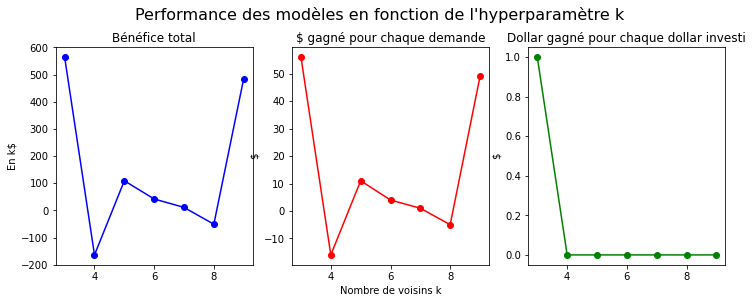

In [40]:
# Graphique des scores en fonction de l'hyperparamètre k
my_eval.graphiques_benefice(
    df_resultats['valeur paramètre'], df_resultats['Bénéfice Total'], df_resultats['Bénéfice par demande'],
    df_resultats['Bénéfice par dollar'],
    'Nombre de voisins k',
    "Performance des modèles en fonction de l'hyperparamètre k"
)

Effectivement, le modèle est optimal du côté du bénéfice pour un hyperparamètre k = 3 (voisins). Mais il est moins stable que pour k = 5. C'est cette dernière valeur qui va être utilisée pour la suite de l'utilisation de ce modèle car elle représente un bon compromis entre le bénéfice et la stabilité du modèle.


*Fonction by Sandy M.*

temps de calcul : 0.6 sec
Matrice de confusion


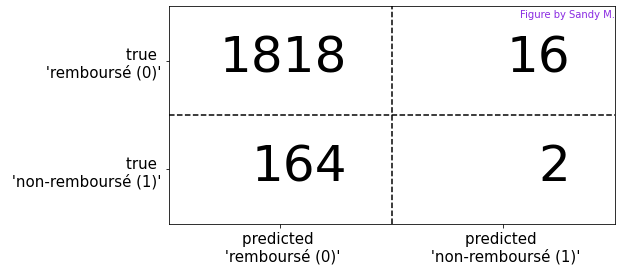

il y a : 
 1818 Vrais Négatifs (le prêt a été remboursé) 
 16 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 164 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 2 Vrais Positifs (le prêt n'a pas été remboursé) 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1834
           1       0.11      0.01      0.02       166

    accuracy                           0.91      2000
   macro avg       0.51      0.50      0.49      2000
weighted avg       0.85      0.91      0.88      2000



In [41]:
prediction, y_test, = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']),
    "TARGET",
    'knn',
    KNeighborsClassifier(n_neighbors=5),
    test_size=0.2)


*Fonction by Sandy M.*

la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  94299.0 k$
le bénéfice sans modèle est  -39610.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  54689.0 k$
le bénéfice supplémentaire sans modèle est  0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  10.86 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  0.11 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  54340.0 k$
la somme supplémentaire perdue avec modèle est  54231.0 k$
le bénéfice supplémentaire avec modèle est  109.0 k$


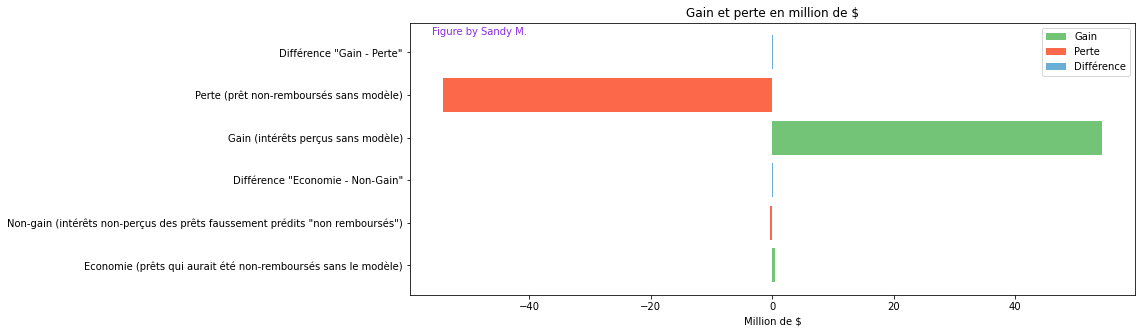

In [42]:
my_eval.benefice(y_test, prediction, df, graph='oui', texte='oui')

### effet cv / stratification / stratification kflod

Notre base de données est fortement déséquilibrée au niveau de la classe de la cible (92% de '0' et 8% de '1'). Nous allons regarder si nous pouvons utiliser une méthode de validation (croisée, par stratification) qui peut améliorer notre modèle et ainsi contre-carrer le problème de déséquilibre.

#### Validation croisée

In [43]:
df_resultats = []
i = 0

for ch_cv in range(2, 10):
    prediction, y_test, temps = my_mdl_s.eval_cv(
        df.drop(columns=['SK_ID_CURR']),
        "TARGET",
        'knn',
        KNeighborsClassifier(n_neighbors=5),
        ch_cv=ch_cv)

    benef, edem, edol = my_eval.benefice(
        y_test, prediction, df, return_values='oui')

    df_resultats = my_eval.tableau_resultats(
        df_resultats, prediction, y_test, 0, 0, temps, benef, edem, edol, ch_cv, i)
    i += 1
df_resultats

,valeur paramètre,errors_train,errors_test,f1_Négatifs,f1_Positifs,recall,f1,temps de calcul,Bénéfice Total,Bénéfice par demande,Bénéfice par dollar
0,2.0,100.0,100.0,0.96,0.04,0.02,0.04,2.1,3304.0,330.0,1.0
1,3.0,100.0,100.0,0.96,0.04,0.02,0.04,2.5,3573.0,357.0,1.0
2,4.0,100.0,100.0,0.96,0.04,0.02,0.04,2.9,3488.0,349.0,1.0
3,5.0,100.0,100.0,0.96,0.04,0.02,0.04,3.1,2648.0,265.0,1.0
4,6.0,100.0,100.0,0.96,0.04,0.02,0.04,3.5,3359.0,336.0,1.0
5,7.0,100.0,100.0,0.96,0.04,0.02,0.04,3.7,3684.0,368.0,1.0
6,8.0,100.0,100.0,0.96,0.05,0.03,0.05,3.9,4950.0,495.0,1.0
7,9.0,100.0,100.0,0.96,0.04,0.02,0.04,4.2,4369.0,437.0,1.0


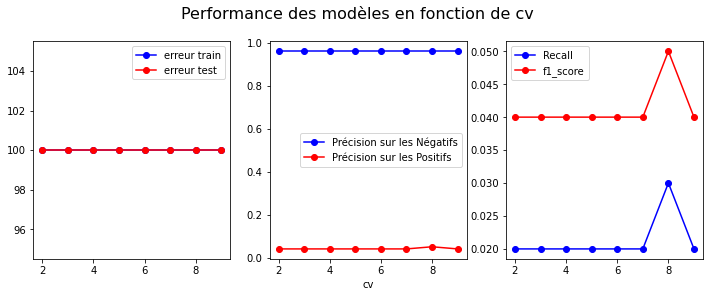

In [44]:
my_eval.graphiques_scores(
    df_resultats['valeur paramètre'], df_resultats['errors_train'],
    df_resultats['errors_test'], df_resultats['f1_Négatifs'],
    df_resultats['f1_Positifs'], df_resultats['recall'], df_resultats['f1'], 'cv',
    'Performance des modèles en fonction de cv'
)

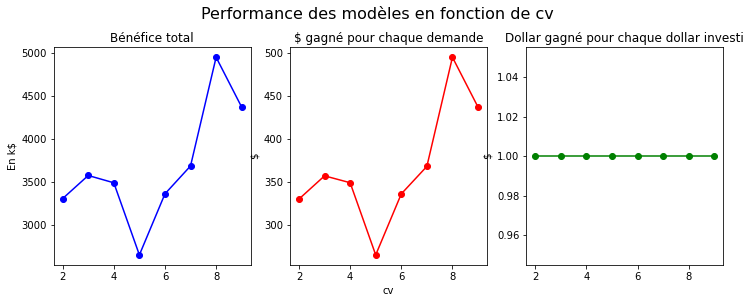

In [45]:
my_eval.graphiques_benefice(
    df_resultats['valeur paramètre'], df_resultats['Bénéfice Total'], df_resultats['Bénéfice par demande'],
    df_resultats['Bénéfice par dollar'],
    'cv',
    'Performance des modèles en fonction de cv'
)

Le modèle semble être optimal pour une validation croisée avec 8 couches.

#### La Stratification Simple

La stratification permet de faire une validation croisée comme précedemment mais cette fois-ci les couches vont avoir une répartition des valeurs plus représentatives de l'ensemble de la base de données.

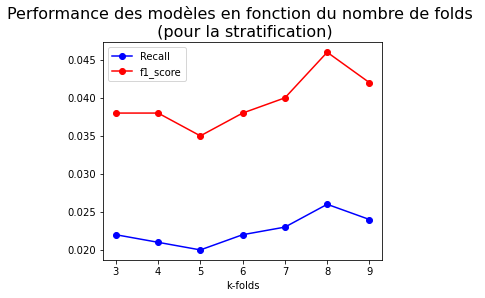

In [46]:
recall = []
f1 = []

for k in range(3, 10):
    r, f = my_mdl_s.eval_stratification(df.drop(columns=['SK_ID_CURR']), "TARGET", 'knn', KNeighborsClassifier(
        n_neighbors=5), StratifiedKFold(n_splits=k))
    recall.append(r)
    f1.append(f)

plt.figure(figsize=(5, 4))
plt.plot(range(3, 10), recall, 'o-b')
plt.plot(range(3, 10), f1, 'o-r')
plt.xlabel('k-folds')
plt.legend(['Recall', 'f1_score'])
plt.title('Performance des modèles en fonction du nombre de folds \n (pour la stratification)', size=16, y=1)
plt.show()

#### La Stratification Shuffle

La stratification Shuffle a le même principe que la stratification présenté precedemment mais elle conserve la proportion en classe de la cible dans les différentes couches. Pour une classe si déséquilibrée que la notre, cela semble est une bonne approche.

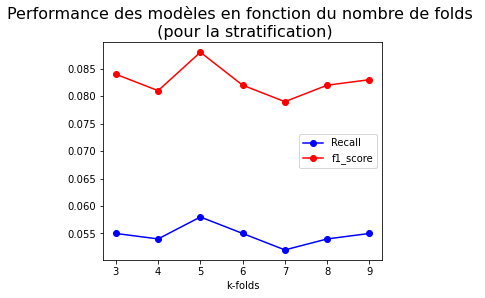

In [47]:
recall = []
f1 = []

for sch in range(3, 10):
    r, f = my_mdl_s.eval_stratification(df.drop(columns=['SK_ID_CURR']), "TARGET", 'knn', KNeighborsClassifier(
        n_neighbors=5), StratifiedShuffleSplit(n_splits=sch, random_state=0))
    recall.append(r)
    f1.append(f)

plt.figure(figsize=(5, 4))
plt.plot(range(3, 10), recall, 'o-b')
plt.plot(range(3, 10), f1, 'o-r')
plt.xlabel('k-folds')
plt.legend(['Recall', 'f1_score'])
plt.title('Performance des modèles en fonction du nombre de folds \n (pour la stratification)', size=16, y=1)
plt.show()

Pour l'instant, on obtient le meilleur recall grâce à la validation croisée avec un maximum de 0.030 pour le recall (contre 0.025 pour la stratification simple et 0.025 pour la stratification shuffle).
Il faut trouver une autre stratégie.

### Influence de SMOTE / SVMOTE

Les méthodes SMOTE et SVMOTE permettent de réquilibrer des échantillons. 

La méthode SMOTE génère de nouveaux échantillons en faisant des combinaisons des données de la classe minoritaire (pour nous 'TARGET') avec celles de leurs voisins proches. Elle permet de faire de l'oversampling afin de proposer une proportion plus efficace de la classe cible.

Attention, avec SMOTE et SVMSMOTE, les pipelines se font avec la librairies imblearn.

<div>
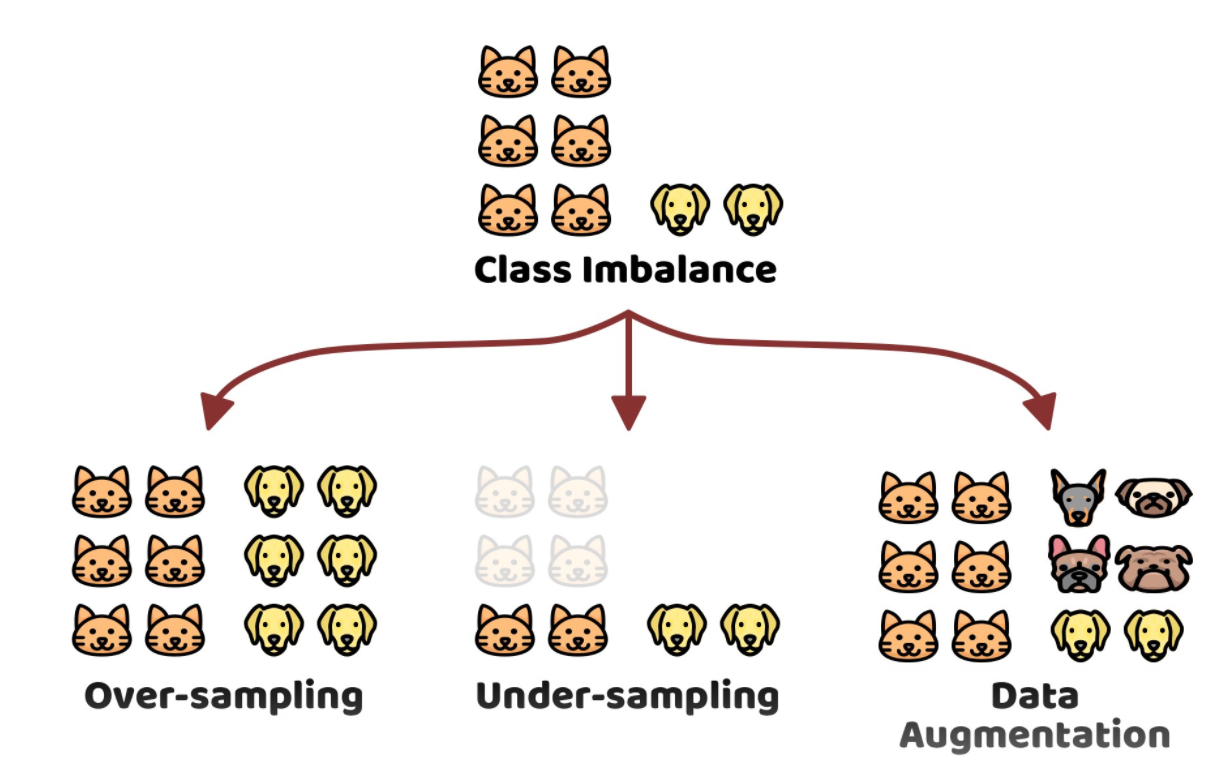
</div>

Source : https://towardsdatascience.com/class-imbalance-random-sampling-and-data-augmentation-with-imbalanced-learn-63f3a92ef04a

#### SMOTE

In [48]:
prediction, y_test, score_train, score_test, temps = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']),
    "TARGET",
    'knn',
    KNeighborsClassifier(n_neighbors=5),
    test_size=sp,
    evaluation='oui', smote=SMOTE(random_state=42, sampling_strategy=0.6))

In [49]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.94      0.52      0.67      7383
           1       0.09      0.60      0.16       617

    accuracy                           0.53      8000
   macro avg       0.52      0.56      0.42      8000
weighted avg       0.87      0.53      0.63      8000




*Fonction by Sandy M.*

la somme gagnée sans modèle est  221863.0 k$
la somme perdue sans modèle est  346923.0 k$
le bénéfice sans modèle est  -125060.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  221863.0 k$
la somme perdue sans modèle est  221863.0 k$
le bénéfice supplémentaire sans modèle est  0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  2875.32 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  12.21 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  122427.0 k$
la somme supplémentaire perdue avec modèle est  93674.0 k$
le bénéfice supplémentaire avec modèle est  28753.0 k$


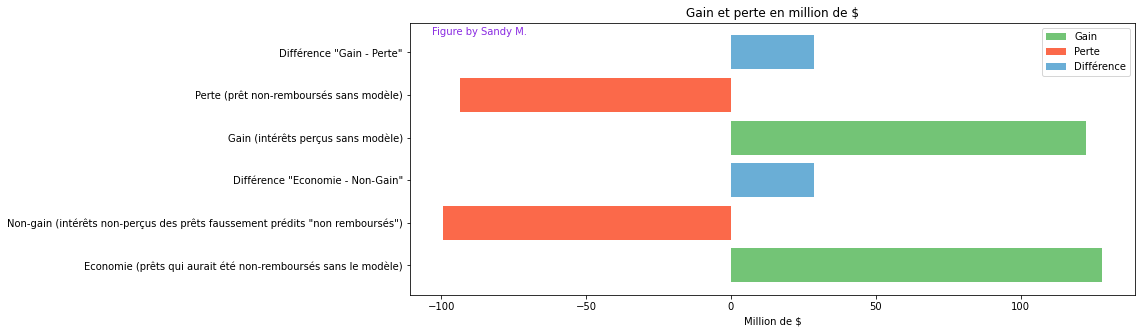

In [50]:
my_eval.benefice(y_test, prediction, df, graph='oui', texte='oui')

Cette méthode change complètement la performance de notre modèle. Elle permet d'avoir un recall similaire sur 0 et 1 (autour de 0.60) et améliore considérablement les bénéfices supplémentaires. De plus, le temps de calcul n'est pas augmenté de façon significative, donc cette méthode reste aussi abordable niveau temps.

#### SVMOTE

La méthode SVMSMOTE repose sur le même principe que la méthode SMOTE. La différence est qu'elle est combinée à une méthode de machine à vecteurs de support (SVM) qui permet d'établir davantage de frontière entre les différentes classes.

In [51]:
prediction, y_test, score_train, score_test, temps = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']),
    "TARGET",
    'knn',
    KNeighborsClassifier(n_neighbors=5),
    test_size=sp,
    evaluation='oui', smote=SVMSMOTE(random_state=42, sampling_strategy=0.6))

In [52]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      7383
           1       0.09      0.48      0.16       617

    accuracy                           0.60      8000
   macro avg       0.51      0.55      0.45      8000
weighted avg       0.87      0.60      0.70      8000



In [53]:
my_eval.benefice(y_test, prediction, df, 'oui')


*Fonction by Sandy M.*

la somme gagnée sans modèle est  221863.0 k$
la somme perdue sans modèle est  346923.0 k$
le bénéfice sans modèle est  -125060.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  221863.0 k$
la somme perdue sans modèle est  221863.0 k$
le bénéfice supplémentaire sans modèle est  0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  2169.35 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  7.93 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  142855.0 k$
la somme supplémentaire perdue avec modèle est  121162.0 k$
le bénéfice supplémentaire avec modèle est  21693.0 k$


Les performances sont légèrement améliorées avec cette méthode. Néanmoins, le temps de calcul est 6 fois plus important. Pour être rentable, il faudra que les bénéfices supplémentaires grâce à ce modèle soient beaucoup plus importants.

La méthode retenue parmi toutes les stratégies pour compenser le déséquilibre de notre classe minoritaire est la méthode SMOTE.

### Influence de la PCA 

Effectuer une analyse en composantes principales avant de procéder à l'apprentissage peut être un bon moyen de gagner en performance. La PCA se fait dans le pipeline, après la standardisation des valeurs numériques.

In [54]:
df_resultats = []
i = 0

for nc in range(5, 100, 5):
    # print(nc)
    prediction, y_test, score_train, score_test, temps = my_mdl_s.modele_simple_basique(
        df.drop(columns=['SK_ID_CURR']),
        "TARGET",
        'knn',
        KNeighborsClassifier(n_neighbors=5),
        evaluation='oui', pca=PCA(nc))
    benef, edem, edol = my_eval.benefice(
        y_test, prediction, df, return_values='oui')

    df_resultats = my_eval.tableau_resultats(
        df_resultats, prediction, y_test, score_train, score_test, temps, benef, edem, edol, nc, i)
    i += 1
df_resultats

,valeur paramètre,errors_train,errors_test,f1_Négatifs,f1_Positifs,recall,f1,temps de calcul,Bénéfice Total,Bénéfice par demande,Bénéfice par dollar
0,5.0,7.61,8.55,0.96,0.02,0.01,0.02,3.9,615.0,62.0,1.0
1,10.0,7.59,8.50,0.96,0.07,0.04,0.07,0.5,1505.0,150.0,1.0
2,15.0,7.60,9.00,0.95,0.03,0.02,0.03,1.7,290.0,29.0,0.0
3,20.0,7.63,8.75,0.95,0.05,0.03,0.05,1.5,1588.0,159.0,2.0
4,25.0,7.61,8.70,0.95,0.06,0.04,0.06,0.7,1141.0,114.0,1.0
5,30.0,7.39,8.60,0.95,0.04,0.02,0.04,0.7,697.0,70.0,1.0
6,35.0,7.47,8.65,0.95,0.02,0.01,0.02,0.6,51.0,5.0,0.0
7,40.0,7.35,8.75,0.95,0.04,0.02,0.04,0.6,648.0,65.0,1.0
8,45.0,7.39,8.75,0.95,0.04,0.02,0.04,0.6,658.0,66.0,1.0
9,50.0,7.47,9.15,0.95,0.03,0.02,0.03,0.6,169.0,17.0,0.0


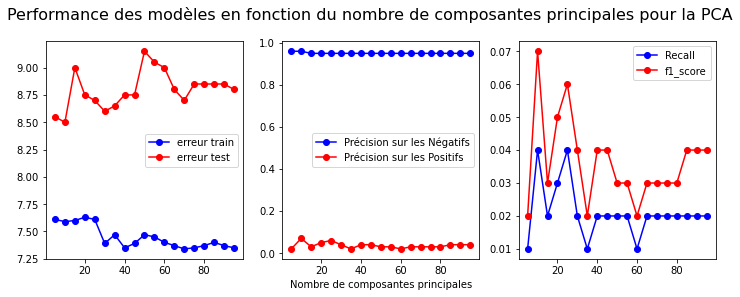

In [55]:
my_eval.graphiques_scores(
    df_resultats['valeur paramètre'], df_resultats['errors_train'],
    df_resultats['errors_test'], df_resultats['f1_Négatifs'],
    df_resultats['f1_Positifs'], df_resultats['recall'], df_resultats['f1'], 'Nombre de composantes principales', 'Performance des modèles en fonction du nombre de composantes principales pour la PCA')

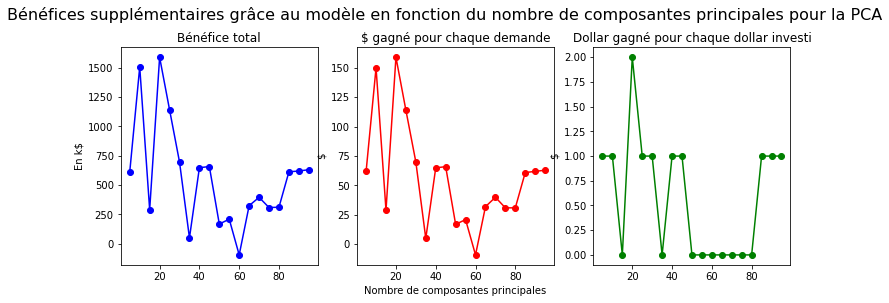

In [56]:
my_eval.graphiques_benefice(
    df_resultats['valeur paramètre'], df_resultats['Bénéfice Total'], df_resultats['Bénéfice par demande'],
    df_resultats['Bénéfice par dollar'],  'Nombre de composantes principales', 'Bénéfices supplémentaires grâce au modèle en fonction du nombre de composantes principales pour la PCA')


*Fonction by Sandy M.*

temps de calcul : 0.6 sec
Matrice de confusion


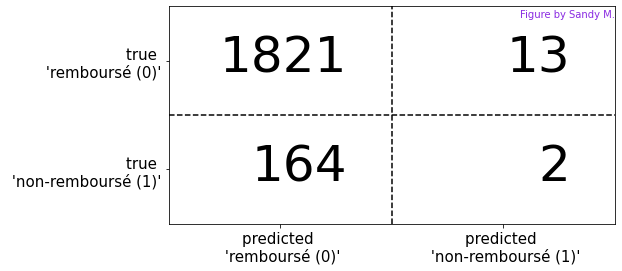

il y a : 
 1821 Vrais Négatifs (le prêt a été remboursé) 
 13 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 164 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 2 Vrais Positifs (le prêt n'a pas été remboursé) 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1834
           1       0.13      0.01      0.02       166

    accuracy                           0.91      2000
   macro avg       0.53      0.50      0.49      2000
weighted avg       0.85      0.91      0.88      2000



In [57]:
prediction, y_test, = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']),
    "TARGET",
    'knn',
    KNeighborsClassifier(n_neighbors=5),
    pca=PCA(20))


*Fonction by Sandy M.*

la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  94299.0 k$
le bénéfice sans modèle est  -39610.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  54689.0 k$
le bénéfice supplémentaire sans modèle est  0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  16.95 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  0.16 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  54401.0 k$
la somme supplémentaire perdue avec modèle est  54231.0 k$
le bénéfice supplémentaire avec modèle est  170.0 k$


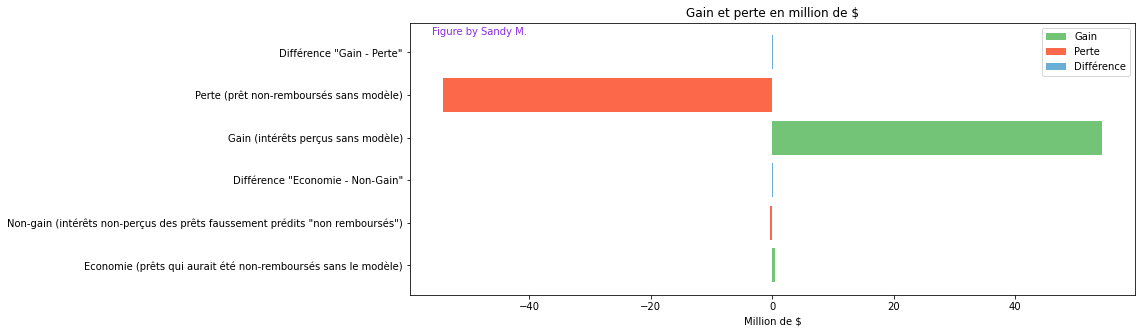

In [58]:
my_eval.benefice(y_test, prediction, df, graph='oui', texte='oui')

## roc / auroc

La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de 1 – spécificité. Elle permet d'évaluer et de comparer différents modèles. L'attribution d'une classe ou d'une autre se fait grâce à un seuil. Par exemple, sous ce seuil, la cible sera de 0 et au dessus de ce seuil la cible sera de 1. La courbe de ROC fait varier ce seuil en commençant à 1 pour terminer à 0. Tout au long de ce déplacement, l'algorithme va calculer le taux de vrai positif (tp) et le taux de faux positif (fp). Nous obtenons donc en ordonnée le taux de tp : la sensibilité, et en abscisse le taux de fp : 1 - spécificité.

Un classement aléatoire va placer les clients au hasard dans la classe cible. L'aire sous la courbe sera de 0.5. C'est l'AUC. 

Dans l'idéal, on cherche un modèle qui permet d'avoir un taux de tp élevé avec un taux de fp le plus faible possible (pour la courbe ROC cela se visualisa par une droite d'ordonnée y = 1, et donc une AUC de 1). On cherche donc à avoir une valeur de AUC la plus grande possible.

Tout au long de l'étude, la courbe ROC de chaque modèle sera tracée avec une courbe ROC d'un dummy Classifier, qui est un modèle qui classe les clients au hasard au sein de la cible.

De plus, une courbe précision-recall est aussi tracée, ces deux scores nous intéressant particulièrement.


*Fonction by Sandy M.*

temps de calcul : 0.9 sec
Matrice de confusion


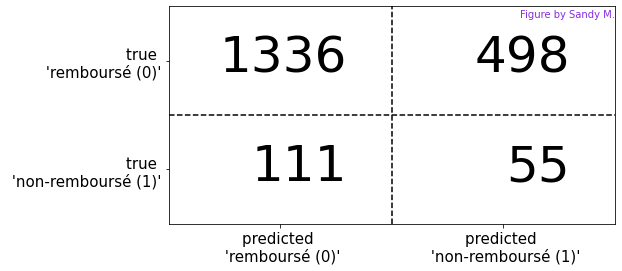

il y a : 
 1336 Vrais Négatifs (le prêt a été remboursé) 
 498 Faux Positifs (le prêt n'a pas été remboursé, le modèle dit que oui) 
 111 Faux Négatifs (le prêt a été remboursé, le modèle dit que non)
 55 Vrais Positifs (le prêt n'a pas été remboursé) 

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1834
           1       0.10      0.33      0.15       166

    accuracy                           0.70      2000
   macro avg       0.51      0.53      0.48      2000
weighted avg       0.85      0.70      0.76      2000

knn : ROC AUC=0.581 Dummy: ROC AUC=0.488


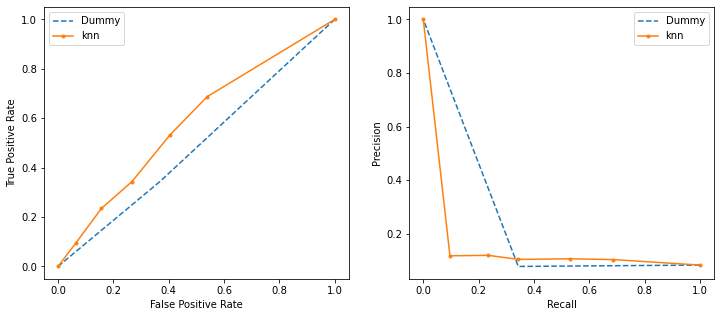

In [59]:
prediction, y_test, lr_auc, temps = my_mdl_s.modele_simple_basique(
    df.drop(columns=['SK_ID_CURR']),
    "TARGET",
    'knn',
    KNeighborsClassifier(n_neighbors=5),
    pca=PCA(20), smote=SMOTE(random_state=42, sampling_strategy=0.6),  afficher_roc='oui')


*Fonction by Sandy M.*

la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  94299.0 k$
le bénéfice sans modèle est  -39610.0 k$
------------------------------------------------------------------------------------------
Après équilibrage des sommes perdues/gagnées :
la somme gagnée sans modèle est  54689.0 k$
la somme perdue sans modèle est  54689.0 k$
le bénéfice supplémentaire sans modèle est  -0.0 k$
------------------------------------------------------------------------------------------
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  198.94 $ par client
Grâce à ce modèle, la banque fait un bénéfice supplémentaire de  2.56 $ pour chaque dollar gagné
------------------------------------------------------------------------------------------
la somme supplémentaire gagnée avec modèle est  40834.0 k$
la somme supplémentaire perdue avec modèle est  38844.0 k$
le bénéfice supplémentaire avec modèle est  1989.0 k$


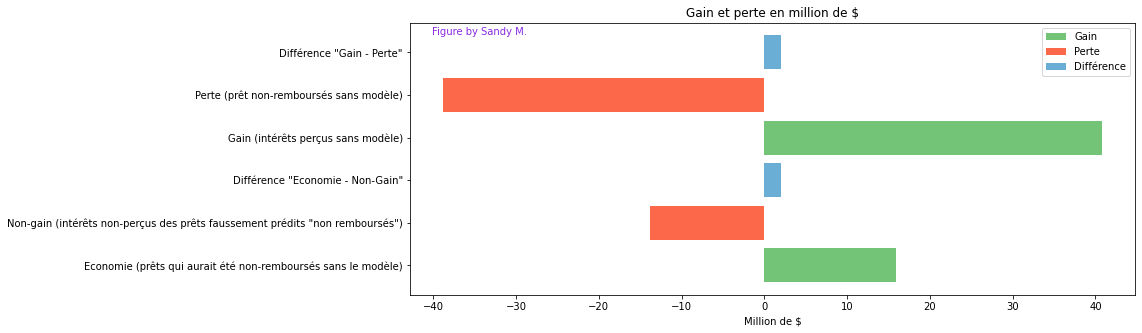

In [60]:
my_eval.benefice(y_test, prediction, df, graph='oui', texte='oui')

# Sources et inspirations

**Classification avec des données déséquilibrées**

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
https://machinelearningmastery.com/what-is-imbalanced-classification/
https://vitalflux.com/class-imbalance-class-weight-python-sklearn/
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4
https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

**Courbes ROC et courbes Precision/Recall**

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

**Pipeline**

https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

# Enregistrement des paramètres

In [62]:
import configparser

config = configparser.ConfigParser()
config['PARAMETRES'] = {
    'MY_PCA': PCA(20),
    'MY_SMOTE': SMOTE(random_state=42, sampling_strategy=0.6)
}
config['MODELES'] = {'MY_KNN': KNeighborsClassifier(n_neighbors=5)}
with open('my_config.ini', 'w') as configfile:
    config.write(configfile)